In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.polynomial import Polynomial # 用拟合多项式来预测
import os

# 需要的数据文件类型为time-expand
# 也就是列为 Country, 1990, 1991,....,2020 ; 行为 CHN,USA 国家名称这样的
# 预测方法是利用前面的点预测下一个点，然后再利用前面的点（包括新增的）预测第二个点, 这样可以为每年设置不同增长速率
# 可以把多个国家预测数据放在一起，把关系曲线绘制在一起
# 预测的数据(csv)在predict目录下
# 生成的图片在predict/chart目录下
# 在最后一年时得到的对所有数据的拟合函数的表达式被放在predict/cruve.txt 里

In [61]:
# 默认读取data文件夹下所有文件csv文件(excel文件请导出为csv)
# 文件名将作为indicator,也就是对比的方面(指标)
# 数据文件中所有已存在年份都将被用来预测，所以想设置年份就删除数据文件中不必要的列
dataFiles = [f for f in os.listdir("./data") if f.endswith(".csv")]
indicators = [".".join(fName.split(".")[:-1]) for fName in dataFiles]
indicator_datas = [pd.read_csv(f"data/{f}") for f in dataFiles]

shared_countries = [country for country in indicator_datas[0]["Country"] if all(map(lambda x: country in list(x["Country"]),indicator_datas))]

if os.path.exists("predict/cruve.txt"):
    os.remove("predict/cruve.txt")

In [62]:
# 仅在这里更改数据
countrys = ["USA","ISR","DNK"] # 更改国家 countries拼写错了，┭┮﹏┭┮，不过还是不要改了
polynomial_dim = 1 # 预测时拟合曲线次数
predict_years = [year for year in range(2021,2024)] # 预测2021-2023年
country_increasement = {
    # 下一年预测数据 = 拟合曲线下下一年数据 * (1 + increasement)
    # 也就是说如果是increasement = 0, 那就按当前预测的趋势发展
    "USA": [0.2 for i in range(len(predict_years))],
    "ISR": [0.06, 0.04,0.02],
    "DNK": [0] * len(predict_years),
}

# 自动检查
assert all(map(lambda x: x in shared_countries,countrys)) # 是否在数据表共有国家里
assert len(country_increasement.keys()) == len(countrys)
assert all(map(lambda x: len(x) == len(predict_years), country_increasement.values()))
assert all(map(lambda x: x in countrys, country_increasement.keys()))

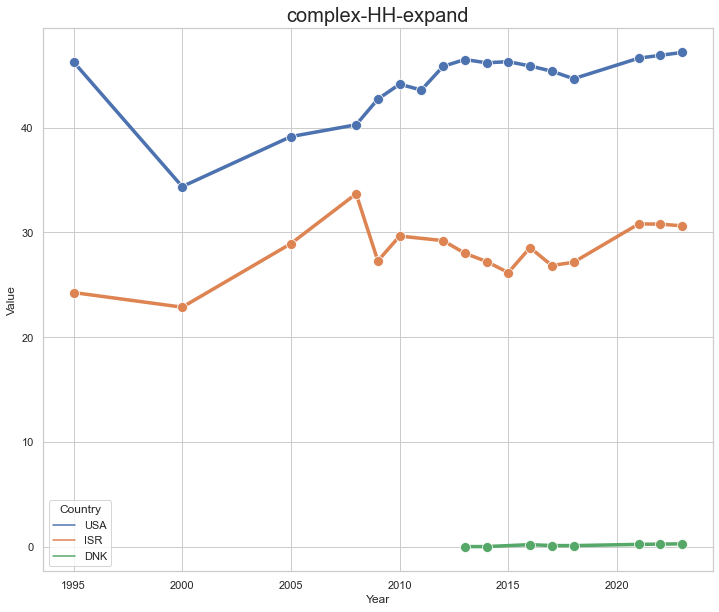

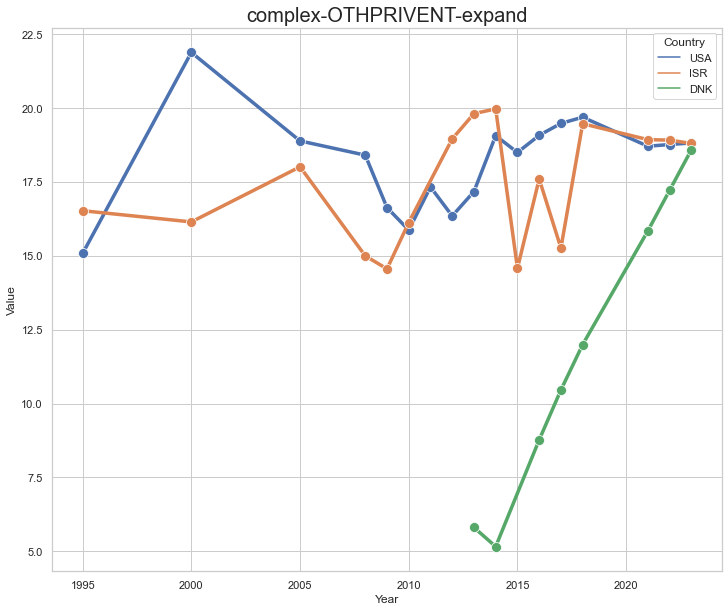

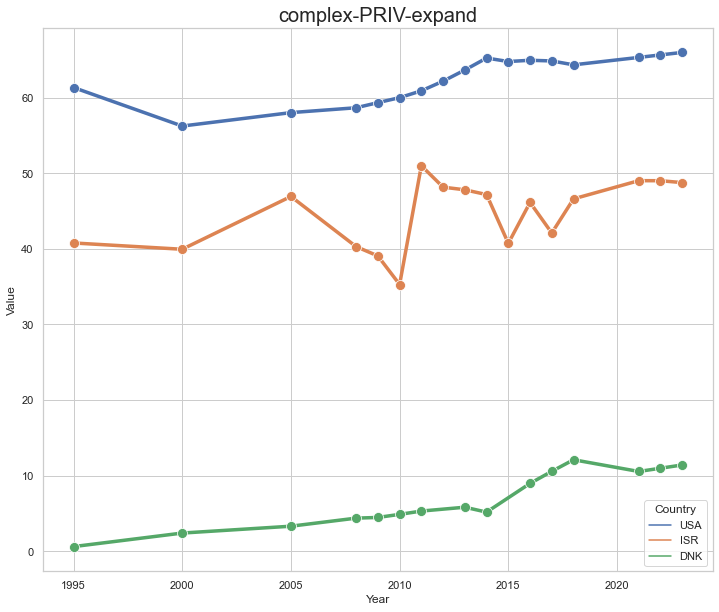

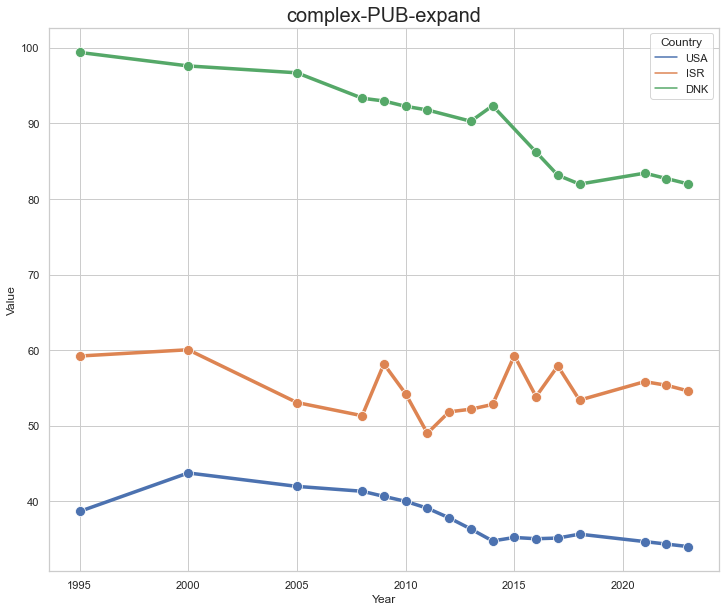

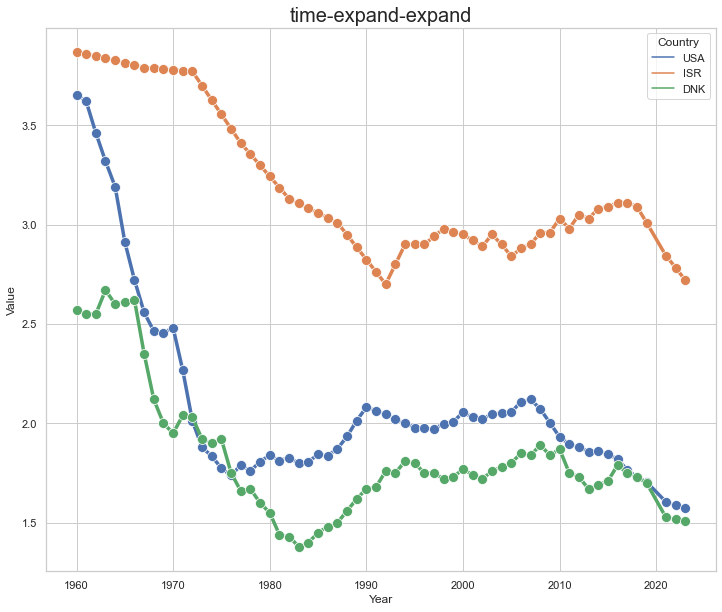

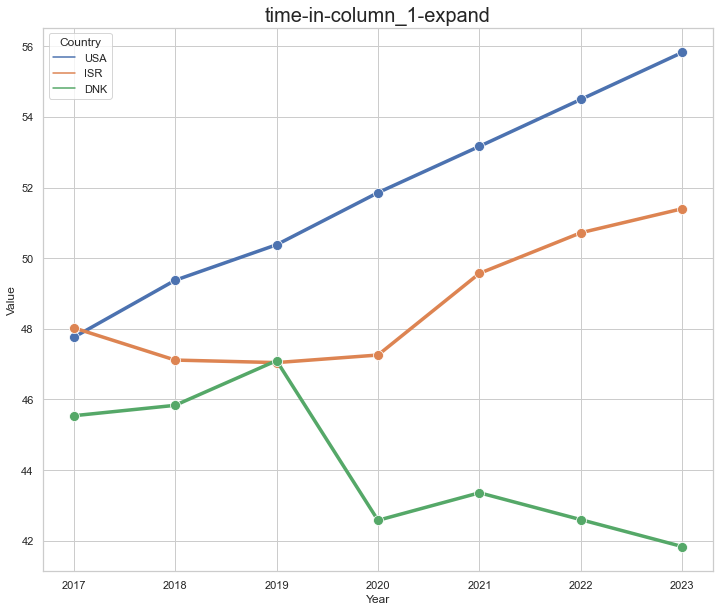

In [63]:
datas = [] # 后续存放数据

for country in countrys:
    res = pd.DataFrame(columns=["Indicator"] + [str(year) for year in predict_years])
    for i in range(len(indicators)):
        tmp = indicator_datas[i]
        indicator = indicators[i]
        indicator_index = 0

        increasement = country_increasement[country]

        tmp = tmp[tmp["Country"] == country]

        tmp = tmp.dropna(axis=1)
        tmp.set_index("Country",inplace=True)
        tmp = tmp.stack().reset_index()
        tmp.columns = ["Country","Year","Value"]
        tmp.drop(columns=["Country"],inplace=True)
        tmp["Year"] = pd.to_numeric(tmp["Year"])
        # tmp.to_csv("test/tmp.csv")

        # print(increasement)
        originLen = len(tmp)
        for j in range(len(predict_years)):
            x = tmp["Year"]
            y = tmp["Value"]
            cruve = Polynomial.fit(x,y,polynomial_dim)
            newVal = cruve(predict_years[0] + j) * (1 + increasement[j])
            tmp.loc[originLen + j] = [predict_years[0]+j ,newVal]
        datas.append(tmp) # 也保留之前年份数据，给后续画图用

        tmp.insert(0,"Indicator",indicator)
        tmp = tmp.pivot("Indicator","Year","Value").rename_axis(columns=None)
        tmp.reset_index(inplace=True)
        tmp = tmp[["Indicator"] + [float(year) for year in predict_years]]
        tmp.columns = ["Indicator"] + [str(year) for year in predict_years]
        # res.loc[indicator_index] = tmp # 不知道为什么报错 哭了
        # res
        # tmp.columns == res.columns
        res = pd.concat([res,tmp])
    res.to_csv(f"predict/{country}.csv")

cruve_file = open("predict/cruve.txt","a")
for indicator_index in range(len(indicators)):
    indicator_data = datas[indicator_index:len(datas):len(indicators)]
    plt.figure(figsize=(12,10))
    sns.set_theme(style="whitegrid")

    cruve_file.write(f"{indicators[indicator_index]}:\n")
    cruves = [Polynomial.fit(country_data["Year"],country_data["Value"],3) for country_data in indicator_data]

    index = 0
    for index in range(len(cruves)):
        cruve = cruves[index]
        country = countrys[index]
        cruve_file.write(f"{country}: {cruve}\n")
    
    for i in range(len(indicator_data)):
        x = indicator_data[i]
        x.insert(0,"Country",countrys[i])
    final = pd.concat(indicator_data)
    final.reset_index(inplace=True,drop=True)
    # print(final)

    g = sns.lineplot(data=final,x="Year",y="Value",hue="Country",marker="o",markersize=10,lw=3.5) # 在这里更改图像的标记点大小和线宽
    g.set_title(final["Indicator"][0],fontsize=20)
    
    cruve_file.write("\n")
    plt.savefig(f"predict/chart/{indicators[indicator_index]}.png",dpi=300)
cruve_file.close() 